# Диплом


[Постановка задачи](#Постановка-задачи) <br>
[Codebook](#Codebook)<br>
[Требования к работе](#Требования-к-работе)<br>
[Критерии оценивания](#Критерии-оценивания)<br>
[Дополнительные материалы](#Дополнительные-материалы) <br>


# Начало

In [ ]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

In [ ]:
import plotly as plotly
import plotly.graph_objects as go

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
#megafon = pd.read_csv("/content/megafon.csv")
#megafon.head()

# Подготовка данных для анализа

In [ ]:
megafon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

In [ ]:
megafon.describe()

Поскольку на вопрос Q2 были допустимы множественные ответы, преобразуем данные так, чтобы каждому ответу Q2 соответствовала отдельная запись.

Сформируем временную таблицу с полями 'user_id'  и  'Q2'

In [ ]:
meg_base=megafon[['user_id','Q2']]
meg_base

,user_id,Q2
0,1,NaN
1,2,4
2,3,4
3,4,3
4,5,"2, 3, 4"
...,...,...
3107,3108,"1, 4, 5"
3108,3109,"1, 3, 4, 5"
3109,3110,NaN
3110,3111,"1, 3"


Заменим пропущенные значения в Q2 на значение не использованное в опросе - 9

In [ ]:
meg_base.fillna(9,inplace=True)
meg_base.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,Q2
0,1,9
1,2,4
2,3,4
3,4,3
4,5,"2, 3, 4"
...,...,...
3107,3108,"1, 4, 5"
3108,3109,"1, 3, 4, 5"
3109,3110,9
3110,3111,"1, 3"


создадим новый датафрейм, с исправленными данными

In [ ]:
new_meg=[]
for index, row in meg_base.iterrows():
  result = list(str(row[1]))
#  print(result)
  for m in range(len(result)):
    if (result[m]!=',') and (result[m]!=' '):
        time_row=[row[0],result[m]]
        new_meg.append(time_row)
new_meg

df_new_mef=pd.DataFrame(new_meg)
df_new_mef.columns=['user_id','Q_2_new']
new_data=df_new_mef.merge(megafon)
new_data


,user_id,Q_2_new,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,9,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,4,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,4,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,3,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68
...,...,...,...,...,...,...,...,...,...,...,...,...
4285,3109,5,3,"1, 3, 4, 5",171.52629,670.32,40.94,2.35,1711.54,2780,954.91,251
4286,3110,9,10,NaN,187.44936,590.29,186.36,2.06,3182.83,2195,1094.62,109
4287,3111,1,6,"1, 3",827.74515,1841.90,373.53,1.21,5675.93,1905,2361.88,202
4288,3111,3,6,"1, 3",827.74515,1841.90,373.53,1.21,5675.93,1905,2361.88,202


In [ ]:
new_data.nunique()

user_id                                      3112
Q_2_new                                         9
Q1                                             49
Q2                                             51
Total Traffic(MB)                            3112
Downlink Throughput(Kbps)                    3102
Uplink Throughput(Kbps)                      2955
Downlink TCP Retransmission Rate(%)           573
Video Streaming Download Throughput(Kbps)    3108
Video Streaming xKB Start Delay(ms)          1882
Web Page Download Throughput(Kbps)           3097
Web Average TCP RTT(ms)                       583
dtype: int64

In [ ]:
new_data.to_csv('new_megafon.csv')

Сохранение подготовленных данных

Сформулируем гипотезы для проверки:

ГИПОТЕЗА 1 "Для всех технических показателей качество оказания услуг для пользователей поставивших баллы 9-10, лучше чем для пользователей поставивших баллы от 1 до 8.


>
ГИПОТЕЗА 2 "Технические показатели собранные техническим отделом, влияют на качество оказания услуг для пользователей поставивших баллы 1-8


> 
ГИПОТЕЗА 3 Опрос проведенный компанией позволит исправить большую часть (более 50%) обращений пользователей высказаных ими в опросе.




---



# Гипотеза 1. Разведочный анализ

Загрузка сохраненных подготовленных данных

In [ ]:
new_data = pd.read_csv("/content/new_megafon.csv")

Выделим данные для пользователей давших на вопрос Q1 оценки 9 и 10 

In [ ]:
new_data_best=new_data[(new_data['Q1']=='9')|(new_data['Q1']=='10')]
#new_data_best.head()

Выделим данные пользователей давших на вопрос Q1 ответы отличные от 9 и 10

In [ ]:
new_data_other=new_data[(new_data['Q1']!='9')&(new_data['Q1']!='10')]
#new_data_other.head()

поскольку, ответы на вопрос Q1, содержит не только цифры

In [ ]:
new_data_other['Q1'].unique()

array(['5', '1', '8', '2', '3', '7', '4', '11', '6', '2, 9', '0', '1, 3',
       '19', '15', nan, '1, 6', '***** ** ***',
       '3 - дер.Ширяево Волоколамского района, 9 - в Москве', '10, 9',
       'Чем даль ше,тем лучше.Спасибо за ваш труд.Оценка 10 !',
       'ОЦЕНКА-3/НЕВАЖНО/', 'Отвратительно',
       'Я ценой услуг не удовлетворен', 'Пока не понял', '3, 9', '5, 6',
       '0, 1, 5', '5, 7', 'Hi',
       '4. Тульская область Заокский район. Романовские дачи связи почти нет',
       'Немагу дать атценку денги незашто снимаеть скоро выклучаю',
       '10, 50',
       'Очень  хорошо. Обслуживания  я довольно. Спасибо вам.555', '?',
       'Поохое',
       'Когда в Москве-10 а когда в калужской области в деревне Бели-1',
       'Нет', 'Да', 'Ужасно',
       '3 тройка, связь отвратительная, жалко платить за такой тарив',
       'Чдтчдтччдтччч', '3, 7', '20, 89031081392', '1, 8', 'Без з',
       '10, 5', '2, 5',
       'Я в Смол. Области живу сейчас, не пользуюсь телефоном совсем'],
  

создадим новый датафрейм только с ответами 1-8.
Прочие ответы в данном исследовании анализировать не будем

In [ ]:
new_data_other_filt=new_data[new_data['Q1'].isin(['1', '2', '3', '4', '5', '6', '7', '8'])]
#new_data_other_filt.head()

In [ ]:
col_all=['Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)','Downlink TCP Retransmission Rate(%)','Video Streaming Download Throughput(Kbps)',
       'Video Streaming xKB Start Delay(ms)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']

In [ ]:
data_best=new_data_best[new_data_best['Q1'].isin(['9','10'])][col_all]
data_no_best=new_data_other_filt[new_data_other_filt['Q1'].isin(['1','2','3','4','5,','7','8'])][col_all]
#data_no_best.head()  

In [ ]:
#data_best

Визуально сравним средние выборочные значения для пользователей удовлетворенных услугами компании и пользователей поставивших оценки 1-8.
Если проверяемая гипотеза верна, то значения средних для группы удовлетворенных услугами (группа «best») будут для всех технических параметров лучше, чем для группы поставившей баллы 1-8 (группа «no_best»)

https://dev-gang.ru/article/sohranit-grafik-kak-izobrazhenie-s-pomosczu-matplotlib-qf2ql46hx8/

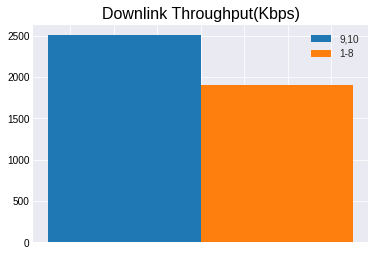

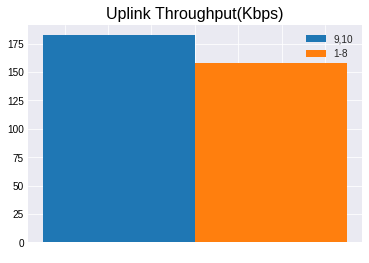

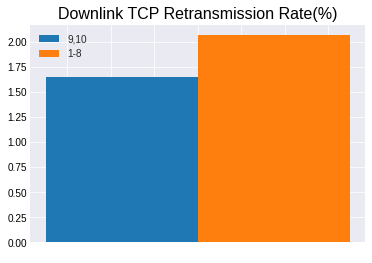

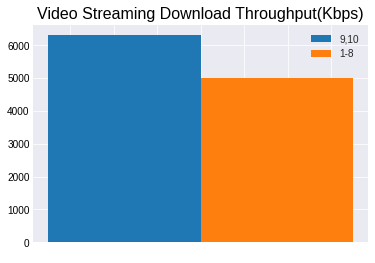

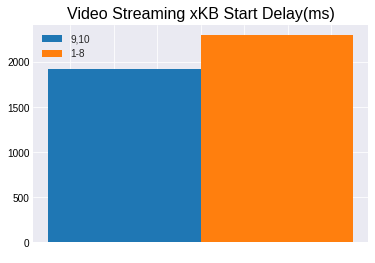

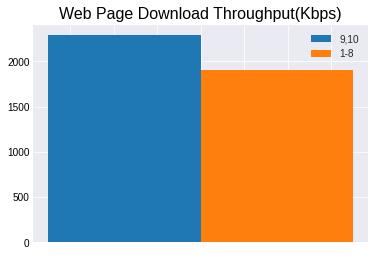

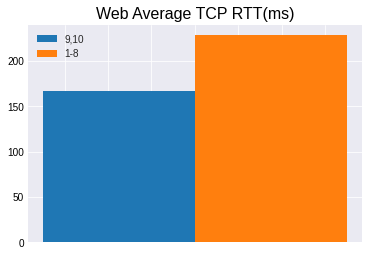

In [ ]:
width = 0.35
for col in col_all:
  fig, ax = plt.subplots() 
  ax.bar(1 - width/2, data_best[col].mean(), width, label='9,10')
  ax.bar(1 + width/2, data_no_best[col].mean(), width, label='1-8')
  ax.tick_params(axis='y',labelcolor='Black')
  ax.set_xticklabels('  ')
  ax.legend() 
  ax.set_title(col,color='Black',fontsize='16')
  fig.savefig('Hip1_' + col,transparent=True)
  plt.show()


Видно , что для всех сравниваемых технических показателей для группы "best", получены более препочтительные для пользователей значения.

Оценим статистическую достоверность наблюдаемых различий

# Гипотеза 1. Статистические тесты

Построим для каждого из исследуемого технического показателя доверительные интервалы для выборочных средних для групп "best" и "no_best".

In [ ]:
import scipy.stats as st
for col in col_all:
  print('Для переменной',col)
  print('Выыборочная средняя bad=',data_no_best[col].mean(),'  good=',data_best[col].mean())
  print('Доверительный интервал bad: ',st.t.interval(0.95, data_no_best[col].count()-1, loc=data_no_best[col].mean(), scale=st.sem(data_no_best[col])),' good: ',st.t.interval(0.95, data_best[col].count()-1, loc=data_best[col].mean(), scale=st.sem(data_best[col])))

Для переменной Downlink Throughput(Kbps)
Выыборочная средняя bad= 1903.8670129870118   good= 2506.0169003690007
Доверительный интервал bad:  (1811.7052618127964, 1996.0287641612272)  good:  (2342.6554811976916, 2669.37831954031)
Для переменной Uplink Throughput(Kbps)
Выыборочная средняя bad= 157.7853705118412   good= 182.43023985239847
Доверительный интервал bad:  (151.01755890600737, 164.55318211767502)  good:  (168.65366239143808, 196.20681731335887)
Для переменной Downlink TCP Retransmission Rate(%)
Выыборочная средняя bad= 2.0656073338426255   good= 1.652730627306272
Доверительный интервал bad:  (1.9739443696409655, 2.1572702980442853)  good:  (1.5443978298287027, 1.7610634247838415)
Для переменной Video Streaming Download Throughput(Kbps)
Выыборочная средняя bad= 4994.800187165788   good= 6303.191808118076
Доверительный интервал bad:  (4814.433017942448, 5175.167356389128)  good:  (5986.712961710575, 6619.6706545255765)
Для переменной Video Streaming xKB Start Delay(ms)
Выыборочна

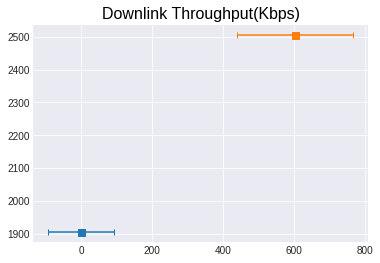

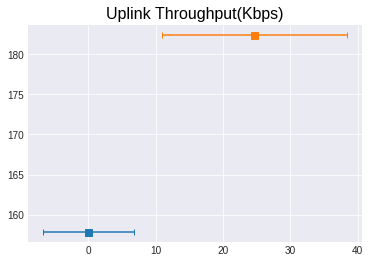

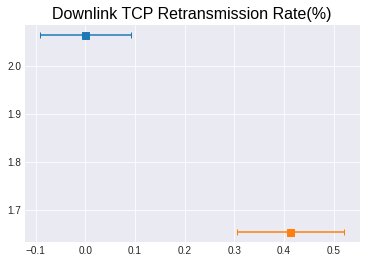

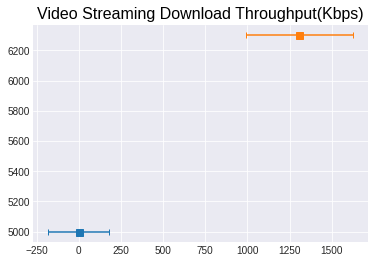

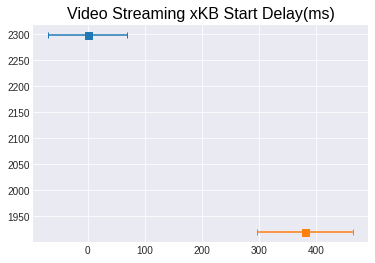

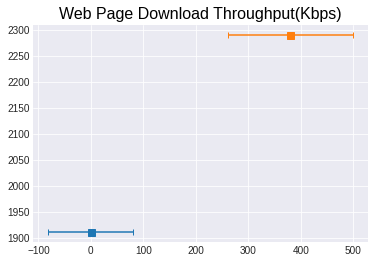

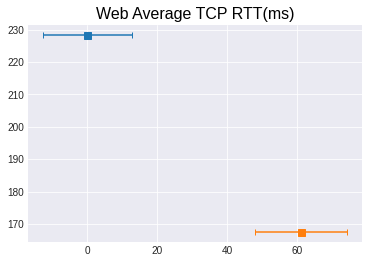

In [ ]:
#col_graph=['Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)','Video Streaming Download Throughput(Kbps)',
#       'Video Streaming xKB Start Delay(ms)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']

#fig, ax = plt.subplots() 
for col in col_all:#col_graph:
  fig, ax = plt.subplots() 
  mean1=data_no_best[col].mean()  
  mean2=data_best[col].mean()

  freedoms1=data_no_best[col].count()-1 
  freedoms2=data_best[col].count()-1
  #dov1=st.t.interval(0.95, freedoms1, loc=mean1)
  #dov2=st.t.interval(0.95, freedoms2, loc=mean2)
  dov1=st.t.interval(0.95, freedoms1, loc=mean1,scale=st.sem(data_no_best[col]))
  dov2=st.t.interval(0.95, freedoms2, loc=mean2,scale=st.sem(data_best[col]))

  err1=dov1[1]-dov1[0]
  err2=dov2[1]-dov2[0]

  #ax.errorbar( 0, mean1,xerr=np.log(err1), capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( 0, mean1,xerr=(err1)/2, capsize=3,linestyle="None",marker="s", markersize=7)
  #ax.errorbar( np.log(abs(mean2-mean1)), mean2, xerr=np.log(err2),capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( (abs(mean2-mean1)), mean2, xerr=(err2)/2,capsize=3,linestyle="None",marker="s", markersize=7)
  
  ax.set_title(col,color='Black',fontsize='16')
  fig.savefig('Dov1_' + col,transparent=True) 
  plt.show()

# Гипотеза 1. Выводы

Как видно из приведенных расчетов для всех технических показателей, доверительные интервалы для выборочных средних, не пересекаются. 
Таким образом можно говорить, что

***ГИПОТЕЗА 1 "Для всех технических показателей качество оказания услуг для пользователей поставивших баллы 9-10, лучше чем для пользователей поставивших баллы от 1 до 8"***

## Принимается.

Подтвердим или опровергнем гипотезу 2:

> 
 "Технические показатели собранные техническим отделом, влияют на качество оказания услуг для пользователей поставивших баллы 1-8"


# Гипотеза 2. Разведочный анализ

В данных пользователей ответивших на вопрос Q1 баллами 1-8, можно выделить 4 группы. 
1.	Пользователи, выбиравшие ответы 1-3, не удовлетворены услугами мобильной связи.
2.	Пользователи, выбравшие ответ 4, не удовлетворены услугами мобильного интернета.
3.	Пользователи выбравшие ответ 5, не удовлетворены услугами доступа к мобильному контенту .
4.	Пользователи, выбравшие ответ 6-7, не удовлетворены иными услугами Компании.

На мой взгляд, технические показатели собранные в анализируемые данные, являются значимыми для оценки качества оказываемых услуг для групп
Q2=4 и Q2=5.
Произведем проверку гипотезы 2 только на данных по этим группам.


Выделим в данных пользователей недовольных услугами (группа "no_best"), данные пользователей связанными с мобильным интернетом (Q2=4)

Данные для  пользователей недовольных мобильным интеренетом (ответ 4 на вопрос Q2)

In [ ]:
internet_user_q2_4=new_data_other_filt[new_data_other_filt['Q_2_new']==4]
internet_user_q2_4.user_id.count()

626

Рассчитаем медианные значения для персонализированных значений технических показателей оказания услуг.
Показатель Total Traffic(MB), в дальнейшем анализе не используется, поскольку на мой взгляд, этот показатель в первую очередь характеризует стиль пользователя, но не имеет однозначного влияния на оценку качества предоставляемых услуг.
Выбор медианного значения, в качестве обощающего оценочного значений характеризующего качество оказания услуги, на стадии разведочного анализа, объясняется более высокой робастностью этой метрики на "коротких" выборках и  позволяет сгладить влияние выбросов.

In [ ]:
internet_user_gr_Q1=internet_user_q2_4.groupby(['Q1'])['Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
       'Downlink TCP Retransmission Rate(%)',
       'Video Streaming Download Throughput(Kbps)',
       'Video Streaming xKB Start Delay(ms)',
       'Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)'].agg('median').reset_index().sort_values(['Q1'])
internet_user_gr_Q1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Q1,Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,951.440,87.110,1.58,2596.580,2094.0,1154.940,158.0
1,2,877.500,99.825,1.74,3386.740,2031.5,1331.895,141.5
2,3,996.380,122.210,1.53,2892.020,1948.0,1372.010,162.0
3,4,1481.070,105.290,1.41,2776.170,2083.0,1329.030,135.0
4,5,1030.215,114.980,1.57,3553.025,1744.5,1415.430,137.5


В разведочном анализе,  для  выбора направлений исследований, значительную роль,играет возможность визуализировать данные в удобном для анализа виде.
Проведем подготовку данных для визуализации.
1. Проведем нормирование данных по каждому техническому показателю.
2. Преобразуем данные в удобный для визуализации вид
3. Визуализируем данные с использованием инстурмента plotly

In [ ]:
internet_user_gr_Q1_norm=internet_user_gr_Q1.set_index('Q1').apply( lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))).reset_index()
internet_user_gr_Q1_norm.head()

,Q1,Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,-0.403547,-0.549736,0.169811,-0.498626,0.496815,-0.430832,0.441860
1,2,-0.514090,-0.308190,0.471698,-0.061755,0.364119,-0.112407,0.058140
2,3,-0.336360,0.117057,0.075472,-0.335280,0.186837,-0.040221,0.534884
3,4,0.388269,-0.204372,-0.150943,-0.399332,0.473461,-0.117563,-0.093023
4,5,-0.285775,-0.020291,0.150943,0.030183,-0.245223,0.037911,-0.034884


Для лучшей визуализации переименуем название технических параметров

In [ ]:
internet_user_gr_Q1_norm.columns=['Q1','Downlink','Uplink','Rate(%)','Video Download','Video Delay(ms)','Web Download','Web RTT']
internet_user_gr_Q1_norm.head()

,Q1,Downlink,Uplink,Rate(%),Video Download,Video Delay(ms),Web Download,Web RTT
0,1,-0.403547,-0.549736,0.169811,-0.498626,0.496815,-0.430832,0.441860
1,2,-0.514090,-0.308190,0.471698,-0.061755,0.364119,-0.112407,0.058140
2,3,-0.336360,0.117057,0.075472,-0.335280,0.186837,-0.040221,0.534884
3,4,0.388269,-0.204372,-0.150943,-0.399332,0.473461,-0.117563,-0.093023
4,5,-0.285775,-0.020291,0.150943,0.030183,-0.245223,0.037911,-0.034884


In [ ]:
internet_user_stack=internet_user_gr_Q1_norm.set_index('Q1').stack().reset_index()
internet_user_stack.columns=['Q1','feature','median']
internet_user_stack

,Q1,feature,median
0,1,Downlink,-0.403547
1,1,Uplink,-0.549736
2,1,Rate(%),0.169811
3,1,Video Download,-0.498626
4,1,Video Delay(ms),0.496815
5,1,Web Download,-0.430832
6,1,Web RTT,0.441860
7,2,Downlink,-0.514090
8,2,Uplink,-0.308190
9,2,Rate(%),0.471698


In [ ]:
px.scatter(internet_user_stack, x='Q1', y='median', facet_col='feature')

Полученные графики наглядно показывают, что существует связь между значениями поставленного балла за качество услуг и медианным значением числовой характеристики оказания услуг. Чем выше оценка, тем выше (в смысле качества), значение технического параметра.

Дополнительно,  визуальный анализ позволяет высказать эмпирическое заключение, что оценки 7 и 8, не во всех случаях являются лучшими, чем значение для балла 6.
На основании этого можно сформулировать дополнительную гипотезу, о том, что  высокие баллы 7 и 8, выставляются пользователями, с учетом ими более широкого круга оцениваниемых характеристик компании, а не только технических показателей



---



Аналогичным образом, без дополнительных пояснений проведем визуализацию данных для пользователей недовольных доступом к видео (ответ 5 на вопрос Q2)

In [ ]:
video_user_q2_5=new_data_other_filt[new_data_other_filt['Q_2_new']==5]
video_user_q2_5.user_id.count()

222

In [ ]:
video_user_gr_Q1=video_user_q2_5.groupby(['Q1'])[['Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
       'Downlink TCP Retransmission Rate(%)',
       'Video Streaming Download Throughput(Kbps)',
       'Video Streaming xKB Start Delay(ms)',
       'Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']].agg('median').reset_index().sort_values(['Q1'])
#video_user_gr_Q1.head()

In [ ]:
video_user_gr_Q1_norm=video_user_gr_Q1.set_index('Q1').apply( lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))).reset_index()
video_user_gr_Q1_norm.columns=['Q1','Downlink','Uplink','Rate(%)','Video Download','Video Delay(ms)','Web Download','Web RTT']
video_user_stack=video_user_gr_Q1_norm.set_index('Q1').stack().reset_index()
video_user_stack.columns=['Q1','feature','median']
video_user_stack

,Q1,feature,median
0,1,Downlink,-0.227214
1,1,Uplink,-0.258356
2,1,Rate(%),0.087798
3,1,Video Download,-0.292486
4,1,Video Delay(ms),0.342684
5,1,Web Download,-0.008499
6,1,Web RTT,0.198718
7,2,Downlink,-0.336646
8,2,Uplink,-0.167401
9,2,Rate(%),0.444940


In [ ]:
px.scatter(video_user_stack, x='Q1', y='median', facet_col='feature')

# Гипотеза 2. Статистический анализ

В блоке статистического анализа проведем проверку гипотез, о достоверности различий в технологических характеристиках оказания услуг для пользователей поставивших высокие и низкие баллы за качество услуг.

Для оценки статистической значимости различий полученных на предыдущем этапе оценим значения доверительных интервалов для выборочного математического ожидания. Для этого определим, размеры выборок для каждого варианта ответа на вопрос Q1.


In [ ]:
count_Q1=internet_user_q2_4.groupby(['Q1'])['Downlink Throughput(Kbps)'].count().reset_index()
count_Q1

,Q1,Downlink Throughput(Kbps)
0,1,165
1,2,60
2,3,121
3,4,45
4,5,78
5,6,29
6,7,67
7,8,61


Как предсталяется, для пользователей оценивающих качество мобильного интернета наиболее важными переменными будут:

>     Downlink Throughput(Kbps) — средняя скорость «к абоненту» ;
     Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту»;
     Web Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер;
     Web Average TCP RTT(ms) — пинг при просмотре web-страниц.

Произведем оценку доверительных интервалов, выборчных средних для выбранных переменных.

Основываясь на графике полученном на стадии разведочного анализа выскажем дополнительное упрощающее допущение, о том что данные полученные от пользователей поставивших оценки на вопрос Q1:  1,2,3  можно объединить в группу «плохо», а данные  ответивших 6,7,8 в группу «хорошо».
Для подтверждения гипотезы 2 необходимо чтобы для всех или части отобранных параметров лучшие значения советуют группе «хорошо».
Для этого сформируем два массива данных сгруппированных по приставленному выше принципу. 

In [ ]:
IU_4_Q2_bad=internet_user_q2_4[internet_user_q2_4['Q1'].isin(['1','2','3'])][['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']]
IU_4_Q2_good=internet_user_q2_4[internet_user_q2_4['Q1'].isin(['6','7','8'])][['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']]

In [ ]:
IU_4_Q2_good.head()

In [ ]:
IU_4_Q2_bad.head()

Визуализируем функции распределения для выбранных переменных:

In [ ]:
col_for_test=['Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<function matplotlib.pyplot.show>

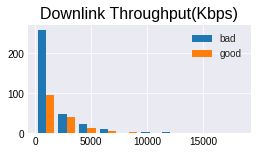

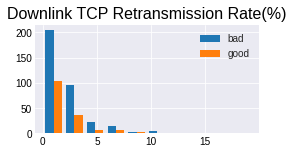

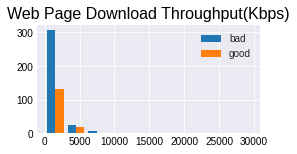

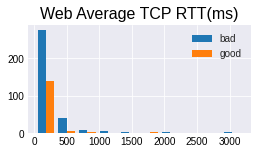

In [ ]:
for col in col_for_test:
  fig, ax1 = plt.subplots(figsize=(4, 2))
  ax1.set_title(col,color='Black',fontsize='16')
  lab=['bad','good']
  ax1.tick_params(axis='both',labelcolor='Black')
  ax1.hist([IU_4_Q2_bad[col],IU_4_Q2_good[col]],bins=10,label=lab)
  ax1.legend(prop={'size': 10})
  fig.savefig('Hip2_Inet' + col,transparent=True)  
plt.show

Как видно распределения не выглядят нормальными.
Возможно данные распределения относятся к логнормальным?
Проверим. Для этого получим новый датафрейм, логарифмов исходных величин.
Поскольку мы используем функцию логарифма исключим из датафрейма данные со значениями меньшими или равными нулю.

In [ ]:
IU_4_Q2_good_log=IU_4_Q2_good[(IU_4_Q2_good['Web Average TCP RTT(ms)']>0)&(IU_4_Q2_good['Web Page Download Throughput(Kbps)']>0)]
#IU_4_Q2_bad_log=internet_user_q2_4[(internet_user_q2_4['Web Average TCP RTT(ms)']!=0)&(internet_user_q2_4['Web Page Download Throughput(Kbps)']!=0)][['Q1','Downlink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)','Web Page Download Throughput(Kbps)', 'Web Average TCP RTT(ms)']]
IU_4_Q2_bad_log=IU_4_Q2_bad[(IU_4_Q2_bad['Web Average TCP RTT(ms)']>0)&(IU_4_Q2_bad['Web Page Download Throughput(Kbps)']>0)]

In [ ]:
IU_4_Q2_good_log=IU_4_Q2_good_log.apply(lambda x: np.log(x))
IU_4_Q2_bad_log=IU_4_Q2_bad_log.apply(lambda x: np.log(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<function matplotlib.pyplot.show>

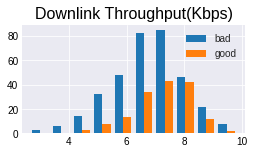

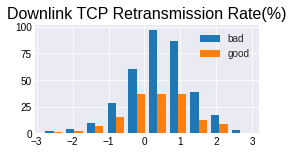

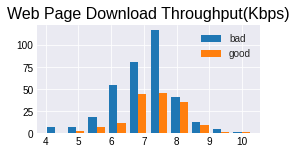

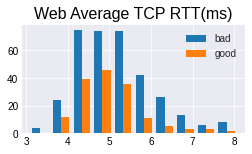

In [ ]:
for col in col_for_test:
  fig, ax1 = plt.subplots( nrows=1, ncols=1,figsize=(4, 2))
  ax1.set_title(col,color='Black',fontsize='16')
  ax1.tick_params(axis='both',labelcolor='Black')
  plt.hist([IU_4_Q2_bad_log[col],IU_4_Q2_good_log[col]],bins=10,label=['bad','good'])
  ax1.legend(prop={'size': 10}) 
  fig.savefig('Hip2_Inet_log_' + col,transparent=True)   
plt.show

Как видно полученные диаграммы визуально ближе к привычному нормальному распределению.
Дальнейший анализ будем проводить с этими обновленными данными

Для вычисления доверительного интервала воспользуемся функциями библиотеки scipy.
Поскольку выборки достаточно "короткие", воспользуемся t-статистикой

In [ ]:
import scipy.stats as st

In [ ]:
for col in col_for_test:
  print('Для переменной',col)
  print('Выыборочная средняя bad=',np.mean(([IU_4_Q2_bad_log[col]])),'  good=',np.mean(([IU_4_Q2_good_log[col]])))
  print('Доверительный интервал bad: ', st.t.interval(0.95, len(IU_4_Q2_bad_log[col])-1, loc=np.mean(IU_4_Q2_bad_log[col]), scale=st.sem(IU_4_Q2_bad_log[col])),' good: ', st.t.interval(0.95, len(IU_4_Q2_good_log[col])-1, loc=np.mean(IU_4_Q2_good_log[col]), scale=st.sem(IU_4_Q2_good_log[col]))) 

Для переменной Downlink Throughput(Kbps)
Выыборочная средняя bad= 6.758055818841228   good= 7.189574447981046
Доверительный интервал bad:  (6.6282333648616225, 6.887878272820839)  good:  (7.02945209510325, 7.34969680085885)
Для переменной Downlink TCP Retransmission Rate(%)
Выыборочная средняя bad= 0.4403443327422695   good= 0.312425297227471
Доверительный интервал bad:  (0.3478353968339035, 0.5328532686506348)  good:  (0.17630004717208153, 0.4485505472828603)
Для переменной Web Page Download Throughput(Kbps)
Выыборочная средняя bad= 7.060944032263993   good= 7.282319891225137
Доверительный интервал bad:  (6.962829510925006, 7.1590585536029865)  good:  (7.152241479984545, 7.412398302465732)
Для переменной Web Average TCP RTT(ms)
Выыборочная средняя bad= 5.1730648347436325   good= 4.990403059997274
Доверительный интервал bad:  (5.0768859657509715, 5.2692437037362865)  good:  (4.86414156388562, 5.116664556108927)


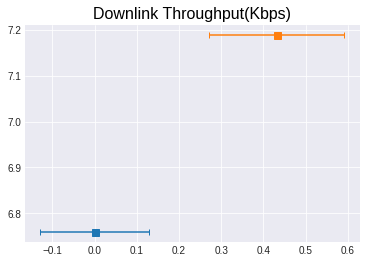

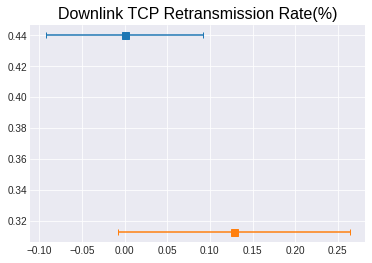

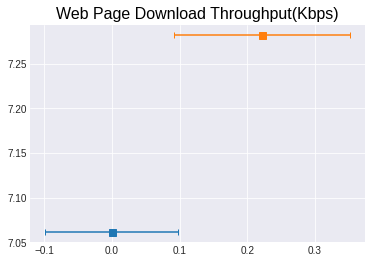

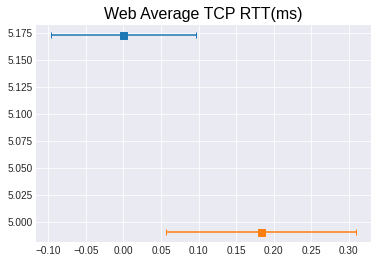

In [ ]:
for col in col_for_test:#col_graph:
  fig, ax = plt.subplots() 
  mean1=IU_4_Q2_bad_log[col].mean()  
  mean2=IU_4_Q2_good_log[col].mean()

  freedoms1=IU_4_Q2_bad_log[col].count()-1 
  freedoms2=IU_4_Q2_good_log[col].count()-1
  dov1=st.t.interval(0.95, freedoms1, loc=mean1,scale=st.sem(IU_4_Q2_bad_log[col]))
  dov2=st.t.interval(0.95, freedoms2, loc=mean2,scale=st.sem(IU_4_Q2_good_log[col]))

  err1=dov1[1]-dov1[0]
  err2=dov2[1]-dov2[0]

  #ax.errorbar( 0, mean1,xerr=np.log(err1), capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( 0, mean1,xerr=(err1)/2, capsize=3,linestyle="None",marker="s", markersize=7)
  #ax.errorbar( np.log(abs(mean2-mean1)), mean2, xerr=np.log(err2),capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( (abs(mean2-mean1)), mean2, xerr=(err2)/2,capsize=3,linestyle="None",marker="s", markersize=7)
  
  ax.set_title(col,color='Black',fontsize='16')
  fig.savefig('Hip2_Dov1_' + col,transparent=True) 
  plt.show()

Как видно из приведенных расчетов, для переменных 

> Downlink TCP Retransmission Rate(%)

> Web Page Download Throughput(Kbps)

> Web Average TCP RTT(ms)

Доверительные интервалы пересекаются и по этой причине невозможно дать однозначного ответа - различаются ли значений выборочных средних, чтобы подтвердить или опровергнуть гипотезу 2.
Для дальнейшего продвижения к решению воспользуемся алгоритмом увеличения размера выборок, "bootstrap" и дальнейшим сравнение получившихся выборок  и проведением теста, на нормальность распределения.







In [ ]:
def get_bootstrap_samples(data, n_samples):
    #indices = np.random.randint(0, len(data), (n_samples, len(data)))
    indices = np.random.randint(0, len(data), (n_samples))    
    samples = data[indices]
    return samples

In [ ]:
import scipy

Проведем описанную процедуру для каждой технической характеристики

Для Downlink TCP Retransmission Rate(%)

In [ ]:
bs1=get_bootstrap_samples(IU_4_Q2_good_log['Downlink TCP Retransmission Rate(%)'].values,1000)
bs2=get_bootstrap_samples(IU_4_Q2_bad_log['Downlink TCP Retransmission Rate(%)'].values,1000)
print('Выборочные средние Good', bs1.mean(),'Bad', bs2.mean())

Выборочные средние Good 0.34650321249201327 Bad 0.4078432928429138


Получим новую переменную разницы между полученными выборками, оценим ее среднее и стандартное отклонение, построим график

In [ ]:
diff=((bs2-bs1))
print(diff.mean(),diff.std())                  

0.06134008035090054 1.270546651807891


(array([  5.,   2.,  10.,  15.,  20.,  30.,  48.,  85., 110., 129., 125.,
        121.,  92.,  71.,  57.,  31.,  29.,  10.,   8.,   2.]),
 array([-4.02535169, -3.6327427 , -3.24013371, -2.84752471, -2.45491572,
        -2.06230673, -1.66969774, -1.27708874, -0.88447975, -0.49187076,
        -0.09926177,  0.29334723,  0.68595622,  1.07856521,  1.4711742 ,
         1.8637832 ,  2.25639219,  2.64900118,  3.04161017,  3.43421917,
         3.82682816]),
 <a list of 20 Patch objects>)

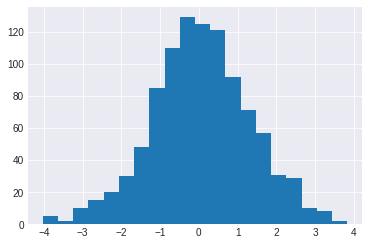

In [ ]:
plt.hist(diff,bins=20)

Проведем  p-value тест Шапиро-Уилка

In [ ]:
stat, p = scipy.stats.shapiro(diff)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.997, p-value=0.122
Принять гипотезу о нормальности


Такм образом принимаем гипотезу о том, что значения для "bad" и "good"  для параметра Downlink TCP Retransmission Rate(%) достоверно статистически различаются.

Для Web Page Download Throughput(Kbps)

In [ ]:
bs1=get_bootstrap_samples(IU_4_Q2_good_log['Web Page Download Throughput(Kbps)'].values,1000)
bs2=get_bootstrap_samples(IU_4_Q2_bad_log['Web Page Download Throughput(Kbps)'].values,1000)
print(bs1.mean(),bs2.mean())

7.276394298551751 7.10025781537857


-0.17613648317318228 1.2741772125306752


(array([  1.,   5.,   4.,  12.,  17.,  26.,  40.,  75., 111., 139., 148.,
        134., 111.,  69.,  44.,  29.,  18.,  12.,   3.,   2.]),
 array([-4.7185288 , -4.28440736, -3.85028593, -3.41616449, -2.98204306,
        -2.54792162, -2.11380018, -1.67967875, -1.24555731, -0.81143588,
        -0.37731444,  0.05680699,  0.49092843,  0.92504987,  1.3591713 ,
         1.79329274,  2.22741417,  2.66153561,  3.09565704,  3.52977848,
         3.96389992]),
 <a list of 20 Patch objects>)

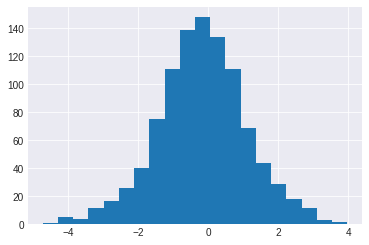

In [ ]:
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  

In [ ]:
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.997, p-value=0.026
Отклонить гипотезу о нормальности


Для данной переменно, гипотеза о статистическом различии отвергается

Проведем проверку для переменной Web Average TCP RTT(ms)

5.065013798492743 5.144805144313672
0.07979134582092945 1.1837447944529083


(array([  2.,   1.,   7.,   8.,  18.,  35.,  31.,  72., 113., 158., 133.,
        127., 103.,  72.,  57.,  37.,  11.,   8.,   6.,   1.]),
 array([-4.13081424, -3.72941635, -3.32801846, -2.92662056, -2.52522267,
        -2.12382478, -1.72242688, -1.32102899, -0.9196311 , -0.5182332 ,
        -0.11683531,  0.28456258,  0.68596048,  1.08735837,  1.48875626,
         1.89015416,  2.29155205,  2.69294994,  3.09434784,  3.49574573,
         3.89714362]),
 <a list of 20 Patch objects>)

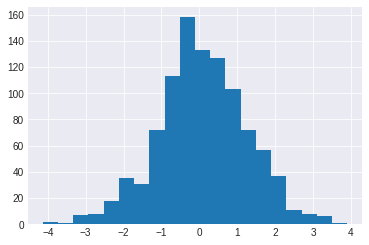

In [ ]:
bs1=get_bootstrap_samples(IU_4_Q2_good_log['Web Average TCP RTT(ms)'].values,1000)
bs2=get_bootstrap_samples(IU_4_Q2_bad_log['Web Average TCP RTT(ms)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  

In [ ]:
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.996, p-value=0.023
Отклонить гипотезу о нормальности


Аналогично предудущему анализу нельзя подвердить статистическую значимость различия между "good" и "bad" выборками для переменной Web Average TCP RTT(ms)

"Разделавшись" с отвечавшими на вопросы о мобильном интернете, проведем исходя из аналогичных предположений с пользователями недовольными доступом к видео контенту.

In [ ]:
col_video=['Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)','Downlink TCP Retransmission Rate(%)','Video Streaming Download Throughput(Kbps)','Video Streaming xKB Start Delay(ms)']

In [ ]:
count_Q1_5=video_user_q2_5.groupby(['Q1'])['Downlink Throughput(Kbps)'].count().reset_index()
count_Q1_5

,Q1,Downlink Throughput(Kbps)
0,1,67
1,2,18
2,3,41
3,4,11
4,5,25
5,6,9
6,7,25
7,8,26


In [ ]:
IU_5_Q2_bad=video_user_q2_5[video_user_q2_5['Q1'].isin(['1','2','3'])][col_video]
IU_5_Q2_good=video_user_q2_5[video_user_q2_5['Q1'].isin(['6','7','8'])][col_video]
IU_5_Q2_good.head()

,Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms)
35,1167.36,30.56,0.48,1560.77,4949
87,2117.83,132.56,2.21,20236.29,648
120,886.86,157.48,2.05,4303.92,3198
143,4973.39,104.63,0.88,4236.16,1261
286,1732.61,132.59,3.90,4526.04,1275


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<function matplotlib.pyplot.show>

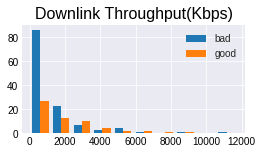

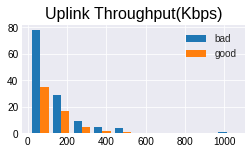

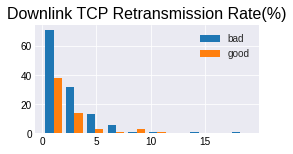

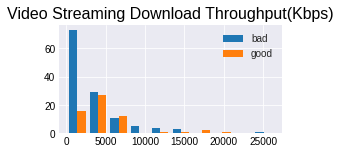

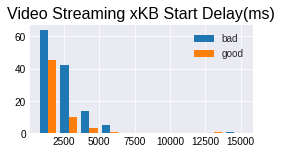

In [ ]:
for col in col_video:
  fig, ax1 = plt.subplots( nrows=1, ncols=1,figsize=(4, 2))
  ax1.set_title(col,color='Black',fontsize='16')
  ax1.tick_params(axis='both',labelcolor='Black')
  plt.hist([IU_5_Q2_bad[col],IU_5_Q2_good[col]],bins=10,label=['bad','good'])
  ax1.legend(prop={'size': 10}) 
  fig.savefig('Hip2_Video_' + col,transparent=True)   
plt.show

In [ ]:
IU_5_Q2_good_log=IU_5_Q2_good[(IU_5_Q2_good['Downlink TCP Retransmission Rate(%)']>0)]
IU_5_Q2_bad_log=IU_5_Q2_bad[(IU_5_Q2_bad['Downlink TCP Retransmission Rate(%)']>0)]
IU_5_Q2_good_log=IU_5_Q2_good_log.apply(lambda x: np.log(x))
IU_5_Q2_bad_log=IU_5_Q2_bad_log.apply(lambda x: np.log(x))
IU_5_Q2_bad_log.head()

,Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms)
9,6.082835,4.398392,0.683097,7.438172,8.348301
17,6.414164,4.405010,1.410987,7.183689,8.116716
58,6.904129,5.005891,2.953347,6.982250,8.189800
94,7.012088,4.610158,-0.235722,8.586876,7.245655
98,5.551680,3.793239,0.223144,6.464993,8.031710


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<function matplotlib.pyplot.show>

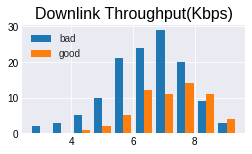

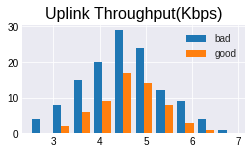

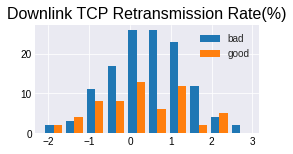

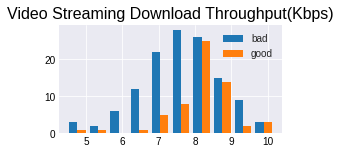

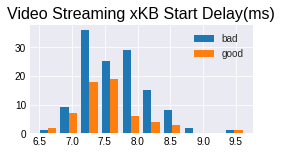

In [ ]:
for col in col_video:
  fig, ax1 = plt.subplots( nrows=1, ncols=1,figsize=(4, 2))
  ax1.set_title(col,color='Black',fontsize='16')
  ax1.tick_params(axis='both',labelcolor='Black')
  plt.hist([IU_5_Q2_bad_log[col],IU_5_Q2_good_log[col]],bins=10,label=['bad','good'])
  ax1.legend(prop={'size': 10})
  fig.savefig('Hip2_Video_log_' + col,transparent=True)    
plt.show

In [ ]:
for col in col_video:
  print('Для переменной',col)
  print('Выборочная средняя bad=',np.mean(([IU_5_Q2_bad_log[col]])),'  good=',np.mean(([IU_5_Q2_good_log[col]])))
  print('Доверительный интервал bad: ', st.t.interval(0.95, len(IU_5_Q2_bad_log[col])-1, loc=np.mean(IU_5_Q2_bad_log[col]), scale=st.sem(IU_5_Q2_bad_log[col])),' good: ', st.t.interval(0.95, len(IU_5_Q2_good_log[col])-1, loc=np.mean(IU_5_Q2_good_log[col]), scale=st.sem(IU_5_Q2_good_log[col]))) 

Для переменной Downlink Throughput(Kbps)
Выборочная средняя bad= 6.487250945007702   good= 7.15951771614115
Доверительный интервал bad:  (6.2639682395892775, 6.710533650426128)  good:  (6.8819323671968915, 7.437103065085409)
Для переменной Uplink Throughput(Kbps)
Выборочная средняя bad= 4.507671637842827   good= 4.636617425685551
Доверительный интервал bad:  (4.355375303623073, 4.659967972062581)  good:  (4.464480466918118, 4.808754384452984)
Для переменной Downlink TCP Retransmission Rate(%)
Выборочная средняя bad= 0.4976469832512157   good= 0.2741531592372439
Доверительный интервал bad:  (0.33748698491228646, 0.6578069815901453)  good:  (0.0036719714046112295, 0.5446343470698767)
Для переменной Video Streaming Download Throughput(Kbps)
Выборочная средняя bad= 7.670342686209952   good= 8.164155792112846
Доверительный интервал bad:  (7.480059831936689, 7.860625540483211)  good:  (7.935986061141215, 8.392325523084478)
Для переменной Video Streaming xKB Start Delay(ms)
Выборочная средняя

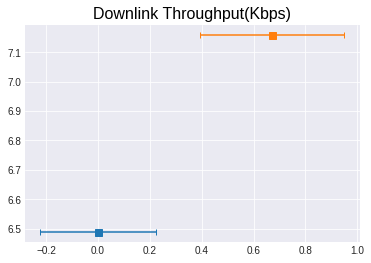

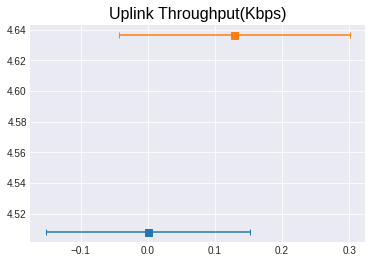

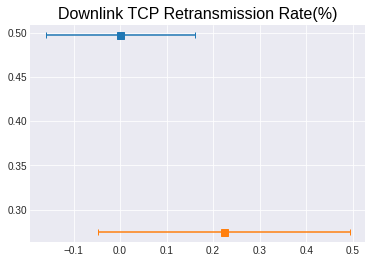

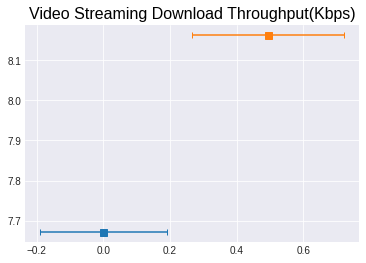

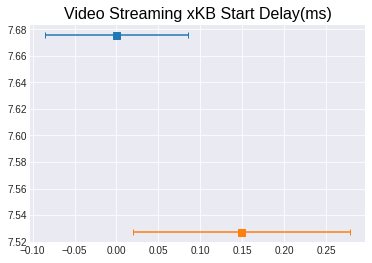

In [ ]:
for col in col_video:#col_graph:
  fig, ax = plt.subplots() 
  mean1=IU_5_Q2_bad_log[col].mean()  
  mean2=IU_5_Q2_good_log[col].mean()

  freedoms1=IU_5_Q2_bad_log[col].count()-1 
  freedoms2=IU_5_Q2_good_log[col].count()-1
  dov1=st.t.interval(0.95, freedoms1, loc=mean1,scale=st.sem(IU_5_Q2_bad_log[col]))
  dov2=st.t.interval(0.95, freedoms2, loc=mean2,scale=st.sem(IU_5_Q2_good_log[col]))

  err1=dov1[1]-dov1[0]
  err2=dov2[1]-dov2[0]

  #ax.errorbar( 0, mean1,xerr=np.log(err1), capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( 0, mean1,xerr=(err1)/2, capsize=3,linestyle="None",marker="s", markersize=7)
  #ax.errorbar( np.log(abs(mean2-mean1)), mean2, xerr=np.log(err2),capsize=3,linestyle="None",marker="s", markersize=7)
  ax.errorbar( (abs(mean2-mean1)), mean2, xerr=(err2)/2,capsize=3,linestyle="None",marker="s", markersize=7)
  
  ax.set_title(col,color='Black',fontsize='16')
  fig.savefig('Hip2_Dov2_' + col,transparent=True) 
  plt.show()

Downlink Throughput(Kbps)

7.215778971449126 6.467505508579508
-0.7482734628696173 1.6586748803246525


(array([  2.,   6.,  15.,  23.,  41.,  70.,  89., 108., 125., 124., 110.,
         85.,  82.,  56.,  31.,  18.,   6.,   7.,   1.,   1.]),
 array([-5.61753743, -5.0902386 , -4.56293977, -4.03564093, -3.5083421 ,
        -2.98104327, -2.45374444, -1.9264456 , -1.39914677, -0.87184794,
        -0.34454911,  0.18274973,  0.71004856,  1.23734739,  1.76464622,
         2.29194506,  2.81924389,  3.34654272,  3.87384155,  4.40114039,
         4.92843922]),
 <a list of 20 Patch objects>)

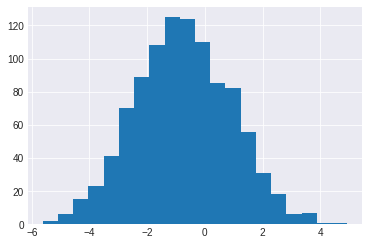

In [ ]:
bs1=get_bootstrap_samples(IU_5_Q2_good_log['Downlink Throughput(Kbps)'].values,1000)
bs2=get_bootstrap_samples(IU_5_Q2_bad_log['Downlink Throughput(Kbps)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  

In [ ]:
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.999, p-value=0.937
Принять гипотезу о нормальности


Для переменной Uplink Throughput(Kbps)

4.645887214088299 4.471975374692657
-0.17391183939564206 1.0797035455374604
Statistics=0.999, p-value=0.593
Принять гипотезу о нормальности


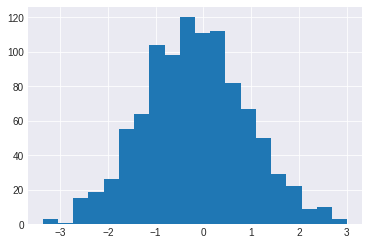

In [ ]:
bs1=get_bootstrap_samples(IU_5_Q2_good_log['Uplink Throughput(Kbps)'].values,1000)
bs2=get_bootstrap_samples(IU_5_Q2_bad_log['Uplink Throughput(Kbps)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Для переменной Downlink TCP Retransmission Rate(%)

0.28886800455500367 0.46595108328552565
0.177083078730522 1.3943719274150823
Statistics=0.999, p-value=0.900
Принять гипотезу о нормальности


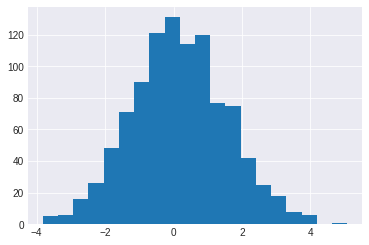

In [ ]:
bs1=get_bootstrap_samples(IU_5_Q2_good_log['Downlink TCP Retransmission Rate(%)'].values,1000)
bs2=get_bootstrap_samples(IU_5_Q2_bad_log['Downlink TCP Retransmission Rate(%)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Для переменной Video Streaming Download Throughput(Kbps)

8.141600356026213 7.676835754661864
-0.46476460136434783 1.3911061714308073
Statistics=0.989, p-value=0.000
Отклонить гипотезу о нормальности


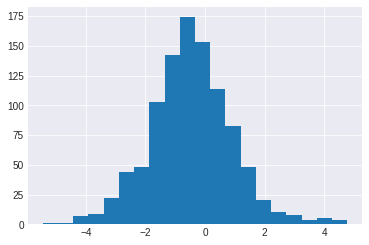

In [ ]:
bs1=get_bootstrap_samples(IU_5_Q2_good_log['Video Streaming Download Throughput(Kbps)'].values,1000)
bs2=get_bootstrap_samples(IU_5_Q2_bad_log['Video Streaming Download Throughput(Kbps)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Для переменной Video Streaming xKB Start Delay(ms)

7.520358097137845 7.709956596467874
0.18959849933002995 0.668142154890086
Statistics=0.990, p-value=0.000
Отклонить гипотезу о нормальности


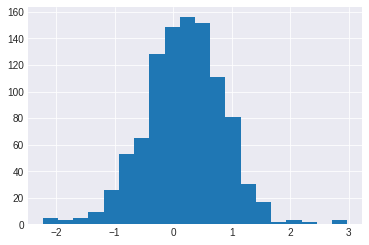

In [ ]:
bs1=get_bootstrap_samples(IU_5_Q2_good_log['Video Streaming xKB Start Delay(ms)'].values,1000)
bs2=get_bootstrap_samples(IU_5_Q2_bad_log['Video Streaming xKB Start Delay(ms)'].values,1000)
print(bs1.mean(),bs2.mean())
diff=((bs2-bs1))
print(diff.mean(),diff.std())
plt.hist(diff,bins=20)  
stat, p = scipy.stats.shapiro(diff) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

#Гипотеза 2. Выводы

Для Пользователей недовольных услугами мобильного интернета
для показателей: ***Downlink Throughput(Kbps)*** и ***Downlink TCP Retransmission Rate(%)*** 
было обнаружено статистического значимое различие качества оказания услуг для пользователей поставивших различные баллы при ответе на вопрос Q1.

Для показателей показателей Web Page Download Throughput(Kbps) и Для переменной Web Average TCP RTT(ms) такого различия обнаружено не было.

Таким образом 
# Гипотеза 2, для группы Пользователей недовольных услугами мобильного интернета
# подтверждена

Для Пользователей недовольных услугами доступа к видео  контенту
для показателей: ***Downlink Throughput(Kbps), Uplink Throughput(Kbps) и Downlink TCP Retransmission Rate(%) *** 
было обнаружено статистического значимое различие качества оказания услуг для пользователей поставивших различные баллы при ответе на вопрос Q1.

Для показателей показателей ***Video Streaming Download Throughput(Kbps) и Video Streaming xKB Start Delay(ms)*** такого различия обнаружено не было.


Таким образом можно аналогично, заключению по пользователем неудовлетворенных мобильным интернетом ,сделать вывод о том что 
# Гипотеза 2, для группы Пользователей недовольных доступомо к видео  контенту
# подтверждена


# Гипотеза 3. Разведочный анализ

Оценим количество пользователей удовлетворенных услугами Мегафон

Оценим количество пользователей не удовлетворенных, по мнению Мегафон услугами компании

В том числе выделим количество пользователей недовольных услугами голосовой связи
Данные для пользователей недовольных прочими сервисами Мегафона (ответ 6, 7 и без ответа на вопрос Q2)

При этом один пользователей мог выбирать сразу несколько вариантов ответа на Q2 и по этой причине пользователей с одним user_id мог попадать одновременно в разные группы. По этой причине в подготовительной части исследования была произведена обработка данных с выделением каждого уникального обращения

Оценим количество пользователей удовлетворенных услугами Мегафон, поскольку для этой группы пользователей ответы на вопрос Q2 не собирались то здесь количество ответов совпадает с число пользователей

In [ ]:
best=new_data_best.user_id.count()
best

1084

Оценим количество ответов отражающих то или иное недовольство услугами компании

In [ ]:
all_no_best=new_data_other_filt.user_id.count()
all_no_best

3152

In [ ]:
user_counts=new_data_other_filt.groupby(['Q_2_new']).user_id.count().reset_index()
user_counts

,Q_2_new,user_id
0,0,6
1,1,648
2,2,185
3,3,706
4,4,626
5,5,222
6,6,13
7,7,87
8,9,659


In [ ]:
def func(x):
    if (x>0) and (x < 4):
        return "Недовольные голосовой связью"
    elif x == 4:
        return "Недовольные мобильным интернетом"
    elif x == 5:
        return "Недовольные доступом к видео"  
    else:
        return 'Другие'
user_counts['type']=user_counts['Q_2_new'].apply(func)
user_type=user_counts.groupby(['type']).user_id.sum().reset_index()
user_type

,type,user_id
0,Другие,765
1,Недовольные голосовой связью,1539
2,Недовольные доступом к видео,222
3,Недовольные мобильным интернетом,626


In [ ]:
#df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
#df.loc[df['pop'] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
fig = px.pie(user_type, values='user_id', names='type', title='Структура ответивших')
fig.show()

В том числе выделим количество ответов пользователей недовольных услугами голосовой связи 

In [ ]:
phones=new_data_other_filt[(new_data_other_filt['Q_2_new']<4)].user_id.count()
phones

1545

В том числе выделим количество ответов пользователей недовольных услугами мобильного интернета

In [ ]:
internet=new_data_other_filt[new_data_other_filt['Q_2_new']==4].user_id.count()
internet

626

В том числе выделим количество ответов пользователей недовольных услугами доступа к видеоконтенту

In [ ]:
video=new_data_other_filt[new_data_other_filt['Q_2_new']==5].user_id.count()
video

222

В том числе выделим количество ответов пользователей недовольных иными услугами Компании

In [ ]:
other=new_data_other_filt[(new_data_other_filt['Q_2_new']>5)].user_id.count()
other

759

# Гипотеза 3. Выводы

Представленные в датасете данные не позволяют детализировать технологические причины недовольства самой большой группы недовольных - голосовой связь. Также данные не позволяют отреагировать на недовольство группы пользователей высказавших свои личные пожелания.
# Не подтверждена

# Заключение
Подведем итоги проведенного исследования. 

В задании стояли задачи: 
1.	проанализировать, как зависит (и зависит ли) оценка, которую ставит клиент в опросе, от технических показателей, которые были собраны 
2.	определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними 
Для этого Компанией был проведен опрос и по каждому ответившему собраны технические показатели:

> Total Traffic(MB) — объем трафика передачи данных

>  Downlink Throughput(Kbps) — средняя скорость «к абоненту»;

>  Uplink Throughput(Kbps)— средняя скорость «от абонента»;

> Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту» ;

> Video Streaming Download Throughput(Kbps) — скорость загрузки потокового видео  ;

> Video Streaming xKB Start Delay(ms) — задержка старта воспроизведения видео  ;

> Web Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер  ;

> Web Average TCP RTT(ms) — пинг при просмотре web-страниц 

Для решения поставленной задачи.
Было  сформулировано 3 гипотезы:

ГИПОТЕЗА 1 "Для всех технических показателей качество оказания услуг для пользователей поставивших баллы 9-10, лучше чем для пользователей поставивших баллы от 1 до 8.

ГИПОТЕЗА 2 "Технические показатели собранные техническим отделом, влияют на качество оказания услуг для пользователей поставивших баллы 1-8

ГИПОТЕЗА 3 Опрос проведенный компанией позволит исправить большую часть (более 50%) обращений пользователей высказаных ими в опросе.

ГИПОТЕЗА 1 подтверждена
и тем самым получен ответ на 1 вопрос - да оценка которую ставит клиент зависит от качества оказываемых услуг по тем техническим показателям которые были собраны.

ГИПОТЕЗА 2 подтверждена, для пользователей которые непосредсвенно зависили от качества предоставляемых им услуг определяемых собранными техническими показателями.
И это позволяет ответить на 2 вопрос, определены технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, это:
*** Downlink Throughput(Kbps) и Downlink TCP Retransmission Rate(%)*** для пользователей мобильного интерента
и ***Downlink Throughput(Kbps), Uplink Throughput(Kbps) и Downlink TCP Retransmission Rate(%)***
для пользователей услугами доступа к видео контенту.
На улучшение этих параметров необходимо направить ресурсы.

Гипотеза 3, оказалась неподтвержденной, поскольку даже если компания напрвит все усилия на повышение качества параметров ***Downlink Throughput(Kbps), Uplink Throughput(Kbps) и Downlink TCP Retransmission Rate(%)***
окажутся неудовлетворенными обращения пользователей голосовой связи которые составляют 49.02% от общего числа и прочие обращения -24.08%.

По этому поводу предлагается получить данные, содержащие технические и не технические показатели, отражающие проблемы неохваченной части опрошенных и провести дополнительный анализ для более полного учета замечаний к работе Компании.
